In [3]:
from utils.functions import *
import pandas as pd
import numpy as np
from keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [4]:
df = pd.read_csv('data/aus_open_matches_with_features.csv')

df = df.dropna()

df['diff_rank'] = df['player_0_rank'] - df['player_1_rank']

In [5]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_hard',
 'diff_games_win_percent_hard',
 'diff_5_set_match_win_percent_hard',
 'diff_close_sets_percent_hard',
 'diff_match_win_percent_60',
 'diff_games_win_percent_60',
 'diff_5_set_match_win_percent_60',
 'diff_close_sets_percent_60',
 'diff_match_win_percent_hard_100',
 'diff_games_win_percent_hard_100',
 'diff_5_set_match_win_percent_hard_100',
 'diff_close_sets_percent_hard_100',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_hard_hh',
 'diff_games_win_percent_hard_hh']

In [6]:
target = df.outcome
features = df[features_list]

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.20, random_state=1)

In [7]:
# Build the Neural Network

network = models.Sequential()
network.add(layers.Dense(units=64, activation='relu', input_shape=(len(features.columns),)))
network.add(layers.Dense(units=32, activation='relu'))
network.add(layers.Dense(units=1, activation='sigmoid'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=500)
mc = ModelCheckpoint('data/best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

history = network.fit(train_features, train_target, 
            epochs=1000, verbose=0, batch_size=128, 
            validation_data=(test_features, test_target), callbacks=[es, mc]) 

saved_model = load_model('data/best_model.h5')




Epoch 00001: val_loss improved from inf to 0.55130, saving model to data\best_model.h5

Epoch 00002: val_loss improved from 0.55130 to 0.53747, saving model to data\best_model.h5

Epoch 00003: val_loss did not improve from 0.53747

Epoch 00004: val_loss improved from 0.53747 to 0.53331, saving model to data\best_model.h5

Epoch 00005: val_loss improved from 0.53331 to 0.51393, saving model to data\best_model.h5

Epoch 00006: val_loss did not improve from 0.51393

Epoch 00007: val_loss improved from 0.51393 to 0.50981, saving model to data\best_model.h5

Epoch 00008: val_loss improved from 0.50981 to 0.49621, saving model to data\best_model.h5

Epoch 00009: val_loss did not improve from 0.49621

Epoch 00010: val_loss improved from 0.49621 to 0.49053, saving model to data\best_model.h5

Epoch 00011: val_loss improved from 0.49053 to 0.48356, saving model to data\best_model.h5

Epoch 00012: val_loss did not improve from 0.48356

Epoch 00013: val_loss did not improve from 0.48356

Epoch 0

In [8]:
# Accuracy of the best model
_, train_acc = saved_model.evaluate(train_features, train_target, verbose=0)
_, test_acc = saved_model.evaluate(test_features, test_target, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))



Train Accuracy: 0.781, Test Accuracy: 0.807


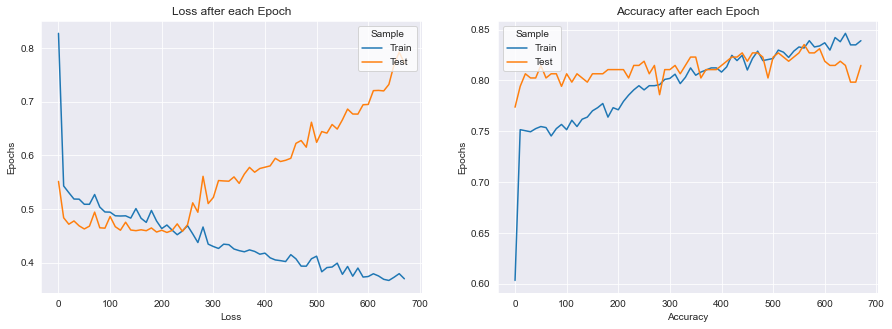

In [9]:
# Graph train/test loss and accuracy
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Loss after each Epoch')
plt.plot(history.epoch[::10], history.history['loss'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_loss'][::10], label='Test')
plt.legend(['Train', 'Test'],loc='upper right', title='Sample', facecolor='white',fancybox=True)
plt.xlabel('Loss')
plt.ylabel('Epochs')

plt.subplot(1, 2, 2)
plt.title('Accuracy after each Epoch')
plt.plot(history.epoch[::10], history.history['accuracy'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_accuracy'][::10], label='Test')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left', title='Sample', facecolor='white', fancybox=True)


plt.savefig('data/loss_acc.jpg', quality=100)

In [10]:
# Test data classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_target, saved_model.predict_classes(test_features)))
print(confusion_matrix(test_target, saved_model.predict_classes(test_features)))

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       190
           1       0.64      0.26      0.37        53

    accuracy                           0.81       243
   macro avg       0.73      0.61      0.63       243
weighted avg       0.78      0.81      0.77       243

[[182   8]
 [ 39  14]]


In [11]:
# Trained data classification report and confusion matrix
print(classification_report(train_target, saved_model.predict_classes(train_features)))
print(confusion_matrix(train_target, saved_model.predict_classes(train_features)))

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.78      0.97      0.87       722
           1       0.74      0.22      0.34       248

    accuracy                           0.78       970
   macro avg       0.76      0.60      0.61       970
weighted avg       0.77      0.78      0.73       970

[[703  19]
 [193  55]]


C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [21]:
# 2021 Australian Open

df_2021 = pd.read_csv('data/ausopen2021.csv')
df_raw = pd.read_csv('data/combined_raw_data.csv', low_memory=False)

df_2021['Date'] = '2021/02/15'
df_2021['Surface'] = 'Hard'
df_2021['diff_rank'] = df_2021['player_0_rank'] - df_2021['player_1_rank']

In [22]:
df_2021 = create_features(df_2021, df_raw)

Creating Player Career Stats All Surface
Creating Player Career Stats on Hard Court
Creating Player Career Stats All Surface Last 60 Weeks
Creating Player Career Stats on Hard Court Last 100 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Hard Court
Creating Difference Variables


In [23]:
# Model Predictions (0 means player_0 will win)
features_16 = df_2021[features_list]

df_2021['prediction'] = saved_model.predict_classes(features_16)
df_2021['probability'] = 1 - np.abs(df_2021.prediction - saved_model.predict_proba(features_16).flatten())

first_prediction = df_2021[['Round', 'player_0', 'player_1', 'prediction', 'probability']]

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [25]:
first_prediction.to_csv("test1.csv", index=False)